# Creación de un ejemplo adversarial

In [1]:

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array

import matplotlib.pyplot as plt
import numpy as np

#cargar MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#preprocesamiento de datos
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

#Definición de clasificador
inputs = Input(shape=(28,28,1))
net = Conv2D(32, kernel_size=(3, 3),
                 activation='relu')(inputs)
net = Conv2D(64, kernel_size=(3, 3),
                 activation='relu')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.25)(net)
net = Flatten()(net)
net = Dense(128, activation='relu')(net)
net = Dropout(0.5)(net)
outputs = Dense(10, activation='softmax')(net)

mnist_model = Model(inputs=inputs, outputs=outputs, name='classification_model')
mnist_model.compile(optimizer='nadam', loss='categorical_crossentropy',metrics=[categorical_accuracy])

#Cargamos clasificador entrenado previamente
mnist_model.load_weights("mnist_clasificador.h5")



#Veamos el error y la tasa de correctos
print(mnist_model.evaluate(x_train, y_train))
print(mnist_model.evaluate(x_test, y_test))

Using TensorFlow backend.


60000/60000 [==============================] - 10s 172us/step
[0.009782723976491797, 0.9971500039100647]
10000/10000 [==============================] - 2s 172us/step
[0.030268934892734887, 0.9904000163078308]


In [2]:
##Funciones auxiliares
def decodifica(pred):
    return np.argmax(pred)

def plotImage( img, dims = False ):
    if not(dims):
        plt.imshow(img, vmin=0., vmax=1.)
    else: 
        plt.imshow(img.reshape(dims), vmin=0., vmax=1.)
    plt.show()

Entrenamiento de clasificador

In [ ]:
#train MNIST classifer
earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=0, mode='auto',
                          baseline=None, restore_best_weights=True)

#mnist_model.fit(x_train, y_train, batch_size=128, epochs=100, verbose=0, validation_data=(x_test, y_test),
#               callbacks=[earlyStop])
mnist_model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=2, validation_data=(x_test, y_test))
mnist_model.save_weights("mnist_clasificador.h5")

Eligamos una imagen para crear ejemplo adversarial

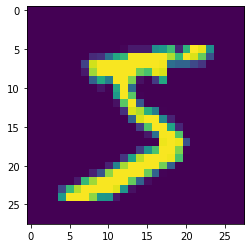

In [3]:
img = x_train[0:1]
plotImage(img, (28,28))

Veamos qué clasificacion da el modelo

In [4]:
prediction = mnist_model.predict(img)[0]
print('Predicción:', decodifica(prediction))


Predicción: 5


In [5]:

#custom activation function for keeping adversarial pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

#custom loss funciton for non-targeted misclassification
def negative_categorical_crossentropy(yTrue,yPred):
    return 0.0 - K.categorical_crossentropy(yTrue,yPred)

#add custom objects to dictionary
get_custom_objects().update({'clip': Activation(clip)})
get_custom_objects().update({'negative_categorical_crossentropy': negative_categorical_crossentropy})


#function for generating an adversarial example given a base image, adversarial class target, classifier, and regularization type
def generate_adversary(img,target,model,regularization,loss_function):
    
    #input for base image
    image = Input(shape=(28,28,1),name='image')
    #unit input for adversarial noise
    one = Input(shape=(1,),name='unity')
    
    #layer for learning adversarial noise to apply to image
    noise = Dense(28*28,activation = None,use_bias=False,kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    #reshape noise in shape of image
    noise = Reshape((28,28,1),name='reshape')(noise)
    
    #add noise to image
    net = Add(name='add')([noise,image])
    #clip values to be within 0.0 and 1.0
    net = Activation('clip',name='clip_values')(net)
    
    #feed adversarial image to trained MNIST classifier
    outputs = model(net)

    adversarial_model = Model(inputs=[image,one], outputs=outputs)
    #freeze trained MNIST classifier layers
    adversarial_model.layers[-1].trainable = False
    
    adversarial_model.compile(optimizer='nadam', loss=loss_function, metrics=[categorical_accuracy])
        
    #target adversarial classification
    target_vector = np.zeros(10)
    target_vector[target] = 1.
    
    #callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('./adversarial_weights_mnist.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True,
                                 mode='auto', period=1)
    #train adversarial image
    adversarial_model.fit(x={'image':img,'unity':np.ones(shape=(1,1))},y=target_vector.reshape(1,-1),epochs=500,verbose=1,
                         callbacks=[checkpoint])
    #restore best weights
    adversarial_model.load_weights('./adversarial_weights.h5')
    
    #quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((28,28)) * 255.) / 255.
    
    #add trained weights to original image and clip values to produce adversarial image
    adversarial_img = np.clip(img.reshape((28,28)) + quantized_weights, 0., 1.)
    
    #display adversarial image
    plt.imshow(adversarial_img,vmin=0., vmax=1.)
    plt.show()
    #classify adversarial image
    adversarial_prediction = mnist_model.predict(adversarial_img.reshape((1,28,28,1)))
    print('Predicción: ',decodifica(adversarial_prediction))
    print('Imagen original')
    plotImage(img, (28,28))
    
    #return adversarial_img


Epoch 1/500
1/1 [==============================] - 0s 160ms/step - loss: -0.0087 - categorical_accuracy: 1.0000
Epoch 2/500
1/1 [==============================] - 0s 3ms/step - loss: -0.6706 - categorical_accuracy: 1.0000
Epoch 3/500
1/1 [==============================] - 0s 3ms/step - loss: -0.0280 - categorical_accuracy: 1.0000
Epoch 4/500
1/1 [==============================] - 0s 3ms/step - loss: -0.1731 - categorical_accuracy: 1.0000
Epoch 5/500
1/1 [==============================] - 0s 3ms/step - loss: -0.0126 - categorical_accuracy: 1.0000
Epoch 6/500
1/1 [==============================] - 0s 3ms/step - loss: -0.2078 - categorical_accuracy: 1.0000
Epoch 7/500
1/1 [==============================] - 0s 3ms/step - loss: -0.4216 - categorical_accuracy: 1.0000
Epoch 8/500
1/1 [==============================] - 0s 3ms/step - loss: -0.0383 - categorical_accuracy: 1.0000
Epoch 9/500
1/1 [==============================] - 0s 4ms/step - loss: -0.8772 - categorical_accuracy: 0.0000e+00
Epoc

1/1 [==============================] - 0s 4ms/step - loss: -10.9215 - categorical_accuracy: 0.0000e+00
Epoch 74/500
1/1 [==============================] - 0s 4ms/step - loss: -11.2177 - categorical_accuracy: 0.0000e+00
Epoch 75/500
1/1 [==============================] - 0s 3ms/step - loss: -9.6462 - categorical_accuracy: 0.0000e+00
Epoch 76/500
1/1 [==============================] - 0s 3ms/step - loss: -13.8430 - categorical_accuracy: 0.0000e+00
Epoch 77/500
1/1 [==============================] - 0s 4ms/step - loss: -4.7791 - categorical_accuracy: 0.0000e+00
Epoch 78/500
1/1 [==============================] - 0s 3ms/step - loss: -10.6560 - categorical_accuracy: 0.0000e+00
Epoch 79/500
1/1 [==============================] - 0s 3ms/step - loss: -15.0696 - categorical_accuracy: 0.0000e+00
Epoch 80/500
1/1 [==============================] - 0s 4ms/step - loss: -9.1895 - categorical_accuracy: 0.0000e+00
Epoch 81/500
1/1 [==============================] - 0s 4ms/step - loss: -13.8058 - categ

Epoch 144/500
1/1 [==============================] - 0s 4ms/step - loss: -39.4777 - categorical_accuracy: 0.0000e+00
Epoch 145/500
1/1 [==============================] - 0s 3ms/step - loss: -26.7742 - categorical_accuracy: 0.0000e+00
Epoch 146/500
1/1 [==============================] - 0s 3ms/step - loss: -31.6242 - categorical_accuracy: 0.0000e+00
Epoch 147/500
1/1 [==============================] - 0s 4ms/step - loss: -31.4338 - categorical_accuracy: 0.0000e+00
Epoch 148/500
1/1 [==============================] - 0s 3ms/step - loss: -21.3850 - categorical_accuracy: 0.0000e+00
Epoch 149/500
1/1 [==============================] - 0s 3ms/step - loss: -19.4284 - categorical_accuracy: 0.0000e+00
Epoch 150/500
1/1 [==============================] - 0s 3ms/step - loss: -21.6715 - categorical_accuracy: 0.0000e+00
Epoch 151/500
1/1 [==============================] - 0s 4ms/step - loss: -21.1516 - categorical_accuracy: 0.0000e+00
Epoch 152/500
1/1 [==============================] - 0s 3ms/step

1/1 [==============================] - 0s 4ms/step - loss: -49.0999 - categorical_accuracy: 0.0000e+00
Epoch 215/500
1/1 [==============================] - 0s 4ms/step - loss: -35.1839 - categorical_accuracy: 0.0000e+00
Epoch 216/500
1/1 [==============================] - 0s 3ms/step - loss: -37.7407 - categorical_accuracy: 0.0000e+00
Epoch 217/500
1/1 [==============================] - 0s 4ms/step - loss: -32.9995 - categorical_accuracy: 0.0000e+00
Epoch 218/500
1/1 [==============================] - 0s 3ms/step - loss: -43.4722 - categorical_accuracy: 0.0000e+00
Epoch 219/500
1/1 [==============================] - 0s 4ms/step - loss: -43.7849 - categorical_accuracy: 0.0000e+00
Epoch 220/500
1/1 [==============================] - 0s 4ms/step - loss: -34.1592 - categorical_accuracy: 0.0000e+00
Epoch 221/500
1/1 [==============================] - 0s 3ms/step - loss: -43.9417 - categorical_accuracy: 0.0000e+00
Epoch 222/500
1/1 [==============================] - 0s 3ms/step - loss: -37.4

Epoch 285/500
1/1 [==============================] - 0s 4ms/step - loss: -44.9429 - categorical_accuracy: 0.0000e+00
Epoch 286/500
1/1 [==============================] - 0s 3ms/step - loss: -38.1697 - categorical_accuracy: 0.0000e+00
Epoch 287/500
1/1 [==============================] - 0s 3ms/step - loss: -32.5747 - categorical_accuracy: 0.0000e+00
Epoch 288/500
1/1 [==============================] - 0s 3ms/step - loss: -38.3279 - categorical_accuracy: 0.0000e+00
Epoch 289/500
1/1 [==============================] - 0s 4ms/step - loss: -20.3468 - categorical_accuracy: 0.0000e+00
Epoch 290/500
1/1 [==============================] - 0s 4ms/step - loss: -56.4586 - categorical_accuracy: 0.0000e+00
Epoch 291/500
1/1 [==============================] - 0s 3ms/step - loss: -42.9650 - categorical_accuracy: 0.0000e+00
Epoch 292/500
1/1 [==============================] - 0s 4ms/step - loss: -53.7086 - categorical_accuracy: 0.0000e+00
Epoch 293/500
1/1 [==============================] - 0s 3ms/step

1/1 [==============================] - 0s 3ms/step - loss: -53.8561 - categorical_accuracy: 0.0000e+00
Epoch 356/500
1/1 [==============================] - 0s 4ms/step - loss: -34.6182 - categorical_accuracy: 0.0000e+00
Epoch 357/500
1/1 [==============================] - 0s 3ms/step - loss: -37.1222 - categorical_accuracy: 0.0000e+00
Epoch 358/500
1/1 [==============================] - 0s 3ms/step - loss: -73.9373 - categorical_accuracy: 0.0000e+00
Epoch 359/500
1/1 [==============================] - 0s 3ms/step - loss: -52.2160 - categorical_accuracy: 0.0000e+00
Epoch 360/500
1/1 [==============================] - 0s 4ms/step - loss: -74.0115 - categorical_accuracy: 0.0000e+00
Epoch 361/500
1/1 [==============================] - 0s 3ms/step - loss: -39.0421 - categorical_accuracy: 0.0000e+00
Epoch 362/500
1/1 [==============================] - 0s 3ms/step - loss: -42.7249 - categorical_accuracy: 0.0000e+00
Epoch 363/500
1/1 [==============================] - 0s 3ms/step - loss: -73.4

Epoch 426/500
1/1 [==============================] - 0s 3ms/step - loss: -85.7726 - categorical_accuracy: 0.0000e+00
Epoch 427/500
1/1 [==============================] - 0s 3ms/step - loss: -63.6021 - categorical_accuracy: 0.0000e+00
Epoch 428/500
1/1 [==============================] - 0s 4ms/step - loss: -42.7880 - categorical_accuracy: 0.0000e+00
Epoch 429/500
1/1 [==============================] - 0s 6ms/step - loss: -72.1338 - categorical_accuracy: 0.0000e+00
Epoch 430/500
1/1 [==============================] - 0s 4ms/step - loss: -75.4224 - categorical_accuracy: 0.0000e+00
Epoch 431/500
1/1 [==============================] - 0s 4ms/step - loss: -41.2256 - categorical_accuracy: 0.0000e+00
Epoch 432/500
1/1 [==============================] - 0s 6ms/step - loss: -81.7864 - categorical_accuracy: 0.0000e+00
Epoch 433/500
1/1 [==============================] - 0s 3ms/step - loss: -68.9316 - categorical_accuracy: 0.0000e+00
Epoch 434/500
1/1 [==============================] - 0s 3ms/step

1/1 [==============================] - 0s 3ms/step - loss: -52.6818 - categorical_accuracy: 0.0000e+00
Epoch 497/500
1/1 [==============================] - 0s 3ms/step - loss: -57.2090 - categorical_accuracy: 0.0000e+00
Epoch 498/500
1/1 [==============================] - 0s 3ms/step - loss: -72.8934 - categorical_accuracy: 0.0000e+00
Epoch 499/500
1/1 [==============================] - 0s 3ms/step - loss: -49.6649 - categorical_accuracy: 0.0000e+00
Epoch 500/500
1/1 [==============================] - 0s 3ms/step - loss: -80.9566 - categorical_accuracy: 0.0000e+00


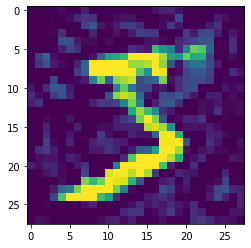

Predicción:  3
Imagen original


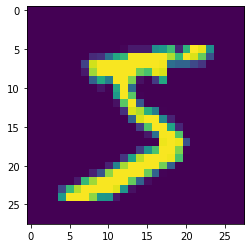

In [7]:
generate_adversary(img,5,mnist_model,l1(0.00001),'negative_categorical_crossentropy')
